This NB demonstrates the xcube **SMOS L2C data store `smos`**.

Inputs:

In [20]:
product_type = "SMOS-L2C-SM"
# product_type = "SMOS-L2C-OS"
time_range = "2022-01-01/2022-01-10"
interval = "3D"

Output:

In [21]:
target_path = f'smos-{time_range.replace("-", "").replace("/", "-")}-{interval.lower()}.zarr'
target_path

'smos-20220101-20220110-3d.zarr'

In [22]:
import json

from IPython.display import JSON
import numpy as np
import pandas as pd
import xarray as xr

from xcube.core.store import find_data_store_extensions
from xcube.core.store import get_data_store_params_schema
from xcube.core.store import new_data_store
from zappend.api import zappend

In [23]:
start_date, stop_date = time_range.split("/", maxsplit=1)
dates = [date.strftime("%Y-%m-%d") for date in pd.date_range(start_date, stop_date, freq=interval)]
time_ranges = [(dates[i], dates[i+1]) for i in range(len(dates) - 1)]
time_ranges

[('2022-01-01', '2022-01-04'),
 ('2022-01-04', '2022-01-07'),
 ('2022-01-07', '2022-01-10')]

In [24]:
with open("creodias-credentials.json") as f:
    credentials = json.load(f)

In [25]:
store = new_data_store(
    'smos', 
    source_path="s3://EODATA", 
    source_storage_options=dict(
        endpoint_url="https://s3.cloudferro.com", 
        anon=False, 
        **credentials
    ),
    cache_path="nc_cache",
    xarray_kwargs=dict(
        engine="h5netcdf"
        #engine="netcdf4"
    )
)

In [26]:
store.get_open_data_params_schema()

In [27]:
JSON(store.list_data_ids())

<IPython.core.display.JSON object>

In [28]:
store.get_data_opener_ids()

('dataset:zarr:smos', 'mldataset:zarr:smos')

In [29]:
# Test store
ds = store.open_data(product_type, 
                     opener_id="dataset:zarr:smos",
                     time_range=time_ranges[0])
ds

<xarray.Dataset>
Dimensions:            (time: 86, lat: 4032, lon: 8192, bnds: 2)
Coordinates:
  * lat                (lat) float64 88.57 88.53 88.48 ... -88.48 -88.53 -88.57
  * lon                (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time               (time) datetime64[ns] 2022-01-01T00:43:53.500000 ... 2...
    time_bnds          (time, bnds) datetime64[ns] dask.array<chunksize=(86, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    Chi_2              (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Chi_2_P            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    N_RFI_X            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    N_RFI_Y            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    RFI_Prob           (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Soil_Moisture      (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Soil_Moisture_DQX  (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>

In [30]:
def generate_datasets(store, time_ranges):
    for time_range in time_ranges:        
        ds = store.open_data("SMOS-L2C-SM", 
                             opener_id="dataset:zarr:smos",
                             time_range=time_range)
        ds_mean = ds.mean("time")
        ds_mean = ds_mean.expand_dims("time", axis=0)
        start, stop = pd.to_datetime(time_range)
        ds_mean.coords["time"] = xr.DataArray(
            np.array([start + (stop - start) / 2]), 
            dims="time", 
            attrs={"bounds": "time_bnds"}
        )
        ds_mean.coords["time_bnds"] = xr.DataArray(
            np.array([[start, stop]]), 
            dims=("time", "bnds")
        )
        yield ds_mean

In [31]:
# Test
ds = next(generate_datasets(store, time_ranges))
ds

<xarray.Dataset>
Dimensions:            (time: 1, lat: 4032, lon: 8192, bnds: 2)
Coordinates:
  * lat                (lat) float64 88.57 88.53 88.48 ... -88.48 -88.53 -88.57
  * lon                (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * time               (time) datetime64[ns] 2022-01-02T12:00:00
    time_bnds          (time, bnds) datetime64[ns] 2022-01-01 2022-01-04
Dimensions without coordinates: bnds
Data variables:
    Chi_2              (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Chi_2_P            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    N_RFI_X            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    N_RFI_Y            (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    RFI_Prob           (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Soil_Moisture      (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>
    Soil_Moisture_DQX  (time, lat, lon) float32 dask.array<chunksize=(1, 4032, 8192), meta=np.ndarray>

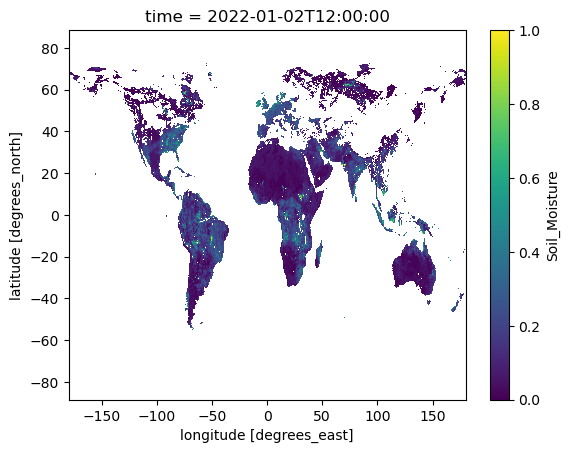

In [32]:
ds.Soil_Moisture.plot()

In [33]:
zappend_config = {
    "target_uri": "./" + target_path, 
    
    "fixed_dims": {
        "lon": 8192,
        "lat": 4032
    },
    
    "append_dim": "time",
    
    "variables": {
        "*": {
            "encoding": {
                "chunks": [1, 2016, 2048]
            }
        },
        "time": {
            "encoding": {
                "chunks": [100]
            }
        },
        "lat": {
            "encoding": {
                "chunks": [4032]
            }
        },
        "lon": {
            "encoding": {
                "chunks": [8192]
            }
        },
    },
    
    # Log to the console.
    # Note you could also configure the log output for dask here.
    "logging": {
        "version": 1,
        "formatters": {
            "normal": {
                "format": "%(asctime)s %(levelname)s %(message)s",
                "style": "%"
            }
        },
        "handlers": {
            "console": {
                "class": "logging.StreamHandler",
                "formatter": "normal"
            }
        },
        "loggers": {
            "zappend": {
                "level": "INFO",
                "handlers": ["console"]
            },
            #"xcube-smos": {
            #    "level": "DEBUG",
            #    "handlers": ["console"]
            #}
        }
    }
}

In [34]:
zappend(generate_datasets(store, time_ranges), config=zappend_config)

2024-01-09 16:18:11,914 INFO Target dataset ./smos-20220101-20220110-3d.zarr not found
2024-01-09 16:18:11,919 INFO Creating target dataset
2024-01-09 16:21:55,592 INFO Target dataset f./smos-20220101-20220110-3d.zarr found
2024-01-09 16:21:55,617 INFO Updating target dataset
2024-01-09 16:22:27,758 ERROR Error in transaction
Traceback (most recent call last):
  File "C:\Users\norma\mamba\envs\xcube\Lib\site-packages\s3fs\core.py", line 1260, in _get_file
    segment_len = f0.write(chunk)
                  ^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\norma\Projects\zappend\zappend\processor.py", line 76, in process_slice
    update_target_from_slice(ctx,
  File "C:\Users\norma\Projects\zappend\zappend\processor.py", line 121, in update_target_from_slice
    slice_ds.to_zarr(store=store,
  File "C:\Users\norma\mamba\envs\xcube\Lib\site-packages\xarra

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/norma/Projects/xcube-smos/notebooks/time/.zarray'